In [1]:
%config IPCompleter.greedy=True

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from nlppreprocess import NLP as npl
from nltk.corpus import stopwords
import nltk
from collections import Counter
import re
plt.style.use('default')
sns.set(style="whitegrid")
pd.options.display.float_format = '{:20,.2f}'.format 

In [3]:
import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\paola\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
df = pd.read_csv("train.csv")
df.drop(columns='id', inplace=True)

In [6]:
df.size

30452

In [7]:
df.describe()

,target
count,"7,613.00"
mean,0.43
std,0.50
min,0.00
25%,0.00
50%,0.00
75%,1.00
max,1.00


In [8]:
df.dtypes

keyword     object
location    object
text        object
target       int64
dtype: object

In [9]:
len(df)

7613

In [10]:
df.keyword.value_counts()

fatalities               45
armageddon               42
deluge                   42
body%20bags              41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [11]:
df.keyword.value_counts(sort=False)

evacuate               40
burning%20buildings    37
bioterrorism           30
obliterate             31
mudslide               37
                       ..
lightning              33
suicide%20bomb         35
hijacking              32
wildfire               33
volcano                27
Name: keyword, Length: 221, dtype: int64

In [12]:
df.location.value_counts()

USA                              104
New York                          71
United States                     50
London                            45
Canada                            29
                                ... 
Portsmouth, UK                     1
Uyo, Akwa Ibom State, Nigeria      1
Ottawa, Ontario                    1
yorkshire\n                        1
ÌÏT: 36.142163,-95.979189          1
Name: location, Length: 3341, dtype: int64

In [13]:
df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [14]:
df['long']= df['text'].apply(lambda x: len(x))
long_max = df['long'].max()
long_max

157

In [15]:
long_min = df['long'].min()
long_min

7

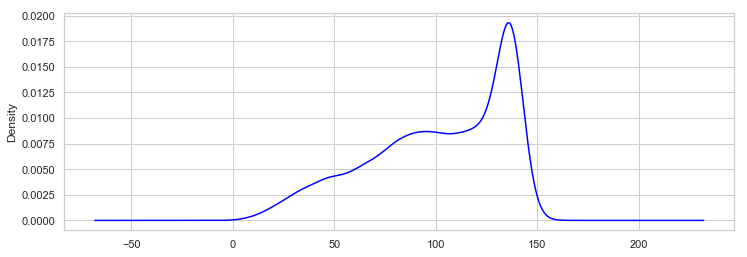

In [16]:
fig = plt.figure(figsize=(12,4))
df.long.plot.kde(color = 'Blue')
plt.show()

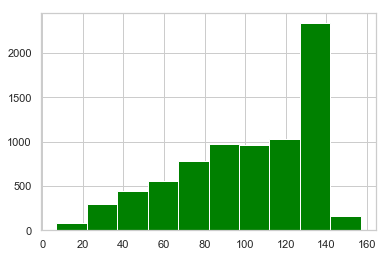

In [17]:
df.long.hist(color='green', bins=10)

In [18]:
long_mean = df['long'].mean()
long_mean

101.03743596479706

In [19]:
df.tail()

,keyword,location,text,target,long
7608,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,83
7609,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,125
7610,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,65
7611,NaN,NaN,Police investigating after an e-bike collided ...,1,137
7612,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1,94


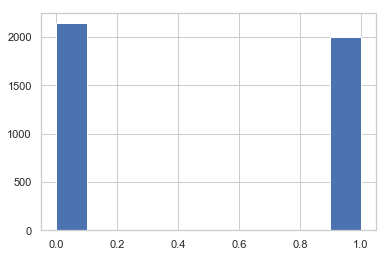

In [20]:
larger_than_mean = df[df['long'] > long_mean]
#larger_than_mean.groupby('target').plot.bar(x='target')
#larger_than_mean.plot.bar(x='target', y=sum(larger_than_mean.groupby('target')))
#plt.bar(larger_than_mean.target, larger_than_mean.target.count())
plt.hist(larger_than_mean.target)
plt.show()

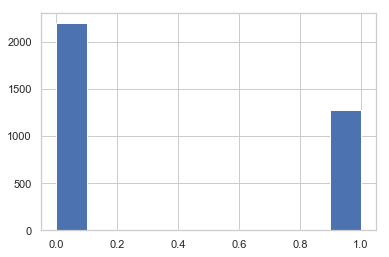

In [21]:
smaller_than_mean = df[df.long < long_mean]
plt.hist(smaller_than_mean.target)
plt.show()

In [22]:
#Busco si los que tienen localizacion tienen mas posibilidad de ser reales

with_loc = df[df.location.notna()]
with_loc.head()

,keyword,location,text,target,long
31,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,55
32,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0,67
33,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,82
34,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,34
35,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,76


In [23]:
len(with_loc)

5080

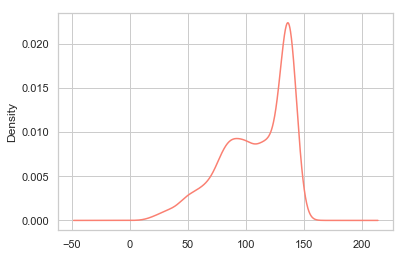

In [24]:
with_loc_real = with_loc[with_loc.target == 1]
with_loc_real.long.plot.kde(color='salmon')

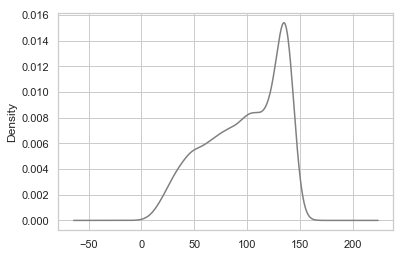

In [25]:
with_loc_false = with_loc[with_loc.target == 0]
with_loc_false.long.plot.kde(color='grey')

In [26]:
len(df.location.isna())

7613

In [27]:
no_loc = df[df.location.isna()]
no_loc.target.value_counts()

0    1458
1    1075
Name: target, dtype: int64

In [28]:
no_loc.tail()

,keyword,location,text,target,long
7608,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,83
7609,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,125
7610,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,65
7611,NaN,NaN,Police investigating after an e-bike collided ...,1,137
7612,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1,94


In [29]:
def suma_target(grouped_k):
    grouped_k['target_suma']= grouped_k['target'].sum()
    return grouped_k

In [30]:
suma=0
#grouped_k['suma'] = df.groupby(['keyword', 'target']).apply(lambda x: suma + x for x in df['target'] if x== 1)
grouped_k= df.groupby(['keyword']).agg({'target':['sum','count']} ).reset_index()
#grouped_k['sum_target'] = grouped_k['target'].apply('sum')
#grouped_k['suma']= grouped_k.apply(lambda x: (suma + x) for x in grouped_k['target'] if (x== 1))
#grouped_k=df.groupby('keyword')#.apply(suma_target)
#grouped_kl['suma']=grouped_kl.target.apply(sum)
level0= grouped_k.columns.get_level_values(0)
level1= grouped_k.columns.get_level_values(1)
grouped_k.columns = level0 + '_' + level1
grouped_k.insert(loc=2, column='cant_falsas', value=(grouped_k.target_count - grouped_k.target_sum))
#col_rename{'target_sum' : 'cant_reales', 'keyword_':'keyword'})
grouped_k.rename(columns={'target_sum' : 'cant_reales', 'keyword_':'keyword'}, inplace=True)
grouped_k

,keyword,cant_reales,cant_falsas,target_count
0,ablaze,13,23,36
1,accident,24,11,35
2,aftershock,0,34,34
3,airplane%20accident,30,5,35
4,ambulance,20,18,38
...,...,...,...,...
216,wounded,26,11,37
217,wounds,10,23,33
218,wreck,7,30,37
219,wreckage,39,0,39


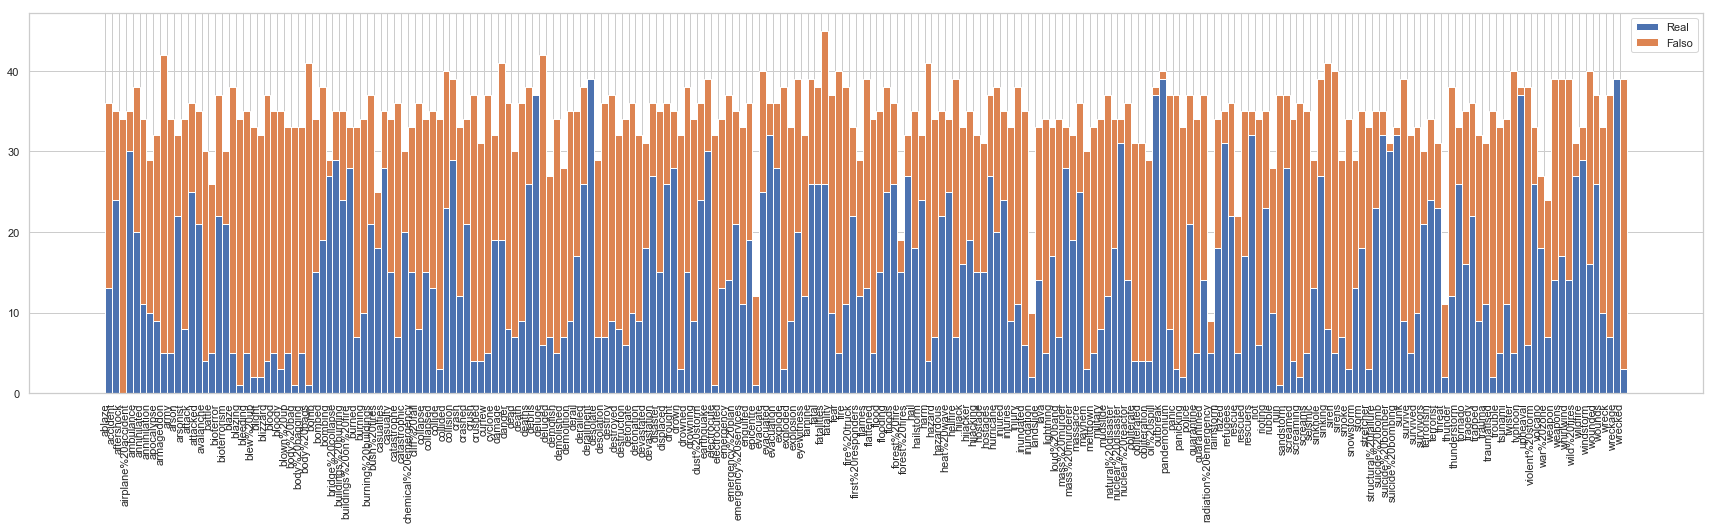

In [31]:
fig = plt.figure(figsize=(30,7))
ax = plt.subplot()
ax.bar(grouped_k.keyword, grouped_k.cant_reales, width = 1, label='Real', align = 'edge')
ax.bar(grouped_k.keyword, grouped_k.cant_falsas, width = 1, bottom=grouped_k.cant_reales, label='Falso', align = 'edge')
plt.xticks(rotation=90)

ax.legend()
plt.show()

In [32]:
stop = stopwords.words('english')

In [33]:
def cuenta_iguales(lista):
    c= Counter(lista)
    count=0
    for key in c:
        if (c[key]>1):
            count+=1
    return count

In [34]:
df['equal_words'] = df.text.agg(lambda x: cuenta_iguales([word for word in x.split() if word not in stop]))


In [35]:
df.head()

,keyword,location,text,target,long,equal_words
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,0
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,0
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,0
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,0
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,0


In [36]:
word_count = df.groupby(['equal_words'])['target'].agg({'sum','count'} ).reset_index()

In [37]:
word_count.head(30)

,equal_words,count,sum
0,0,6465,2810
1,1,905,353
2,2,182,76
3,3,37,16
4,4,15,11
5,5,5,3
6,6,1,0
7,8,2,1
8,9,1,1


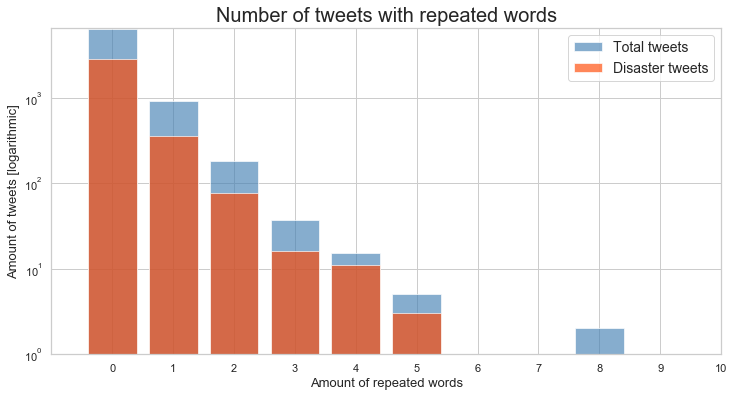

In [38]:
fig,ax = plt.subplots(figsize=(12,6))
cambio = lambda x: 'Total tweets' if (x=='count') else 'Disaster tweets'
colore= {'sum':'orangered', 'count': 'steelblue'}
for name in ['count','sum']:
    #ax.scatter(word_count.equal_words, word_count[name],  marker= 'D', label= cambio(name), c=colore[name])
    ax.bar(word_count.equal_words, word_count[name], label= cambio(name), color=colore[name], alpha = 0.65)
    ax.set_ylim(1,6600)  
    ax.set_xlim(-1,10)
    ax.set_yscale("log")
    plt.legend(fontsize=14)
ax.set_xticks(range(11))
ax.set_ylabel('Amount of tweets [logarithmic]', fontsize=13)
ax.set_xlabel('Amount of repeated words', fontsize=13)
ax.set_title('Number of tweets with repeated words',fontsize=20)
plt.savefig('Rwords.png')

In [39]:
df['Tags']= df['text'].agg(lambda x: x.count('@'))

In [40]:
tag_count = df.groupby(['Tags'])['target'].agg({'sum','count'}).reset_index()
tag_count.head(20)

,Tags,count,sum
0,0,5574,2595
1,1,1553,519
2,2,343,102
3,3,87,41
4,4,31,11
5,5,18,3
6,6,5,0
7,7,1,0
8,8,1,0


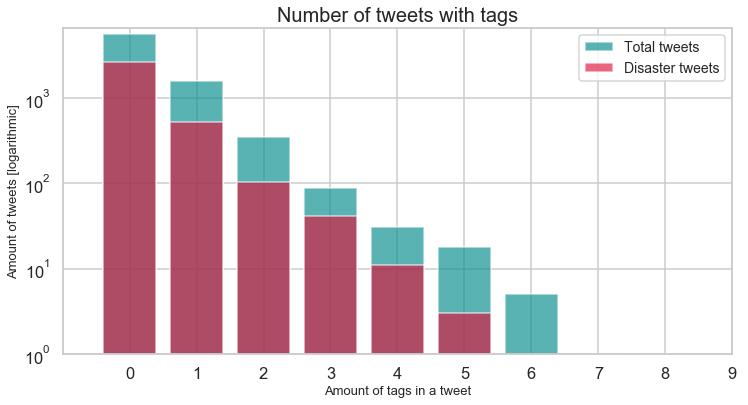

In [63]:

fig,ax = plt.subplots(figsize=(12,6))
tag_count.rename(columns={'sum' : 'Disaster tweets', 'count':'Total tweets'}, inplace=True)
colore= {'Disaster tweets':'crimson', 'Total tweets': 'darkcyan'}
for name in ['Total tweets','Disaster tweets']:
    #ax.scatter(tag_count.Tags, tag_count[name],  marker= 'D' , label=name , c=colore[name])
    ax.bar(tag_count.Tags, tag_count[name], label= cambio(name), color=colore[name], alpha = 0.65)
    ax.set_ylim(1,6600)  
    ax.set_xlim(-1,9)
    ax.set_yscale("log")
    ax.set_xlabel('Amount of tags in a tweet')
    ax.set_ylabel('Amount of tweets')
    plt.legend(['Total tweets', 'Disaster tweets'],fontsize=14)
ax.set_xticks(range(10))
ax.set_ylabel('Amount of tweets [logarithmic]', fontsize=13)
ax.set_xlabel('Amount of tags in a tweet', fontsize=13)
ax.set_title('Number of tweets with tags', fontsize=20)
plt.savefig('Tags.png')

In [42]:
df['with_url']= df.text.str.contains("((https?):((//)|(\\\\))+[\w\d:#@%/;$()~_?\+-=\\\.&]*)", regex=True)

df['with_url']=df['with_url'].astype(int)

In [43]:
url_count = df.groupby(['with_url'])['target'].agg({'sum','count'}).reset_index()

url_count.rename(columns={'sum' : 'Total disasters', 'count':'Total tweets'}, inplace=True)
url_count.head()

,with_url,Total tweets,Total disasters
0,0,3642,1099
1,1,3971,2172


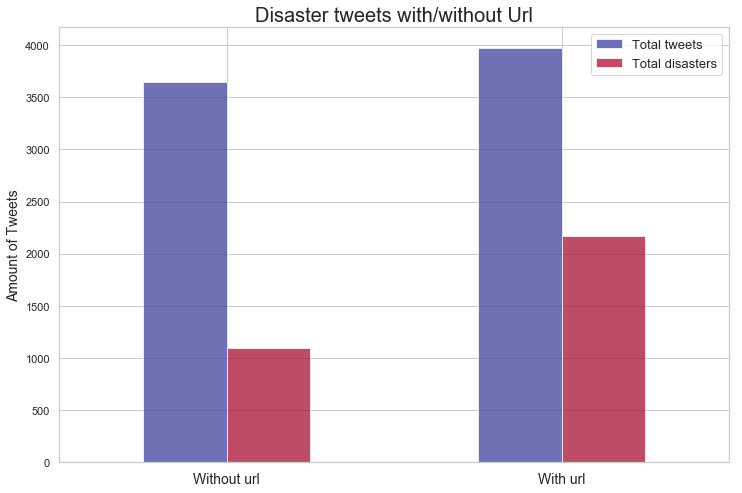

In [44]:
fig = url_count.set_index('with_url').plot(kind='bar', figsize=(12, 8), cmap="RdYlBu_r", alpha=0.7)
fig.axes.set_ylabel('Amount of Tweets', fontsize=14)
fig.axes.set_xlabel('')
fig.axes.legend( fontsize=13)
fig.axes.set_title('Disaster tweets with/without Url', fontsize=20)
fig.axes.set_xticklabels(['Without url', 'With url'], rotation=0, fontsize=14)
plt.savefig('Url.png')

In [45]:
df['with_date'] = df.text.str.contains('((\d{2})[/.-](\d{2})[/.-](\d{4})|(\d{4})[/.-](\d{2})[/.-](\d{2})|(\d{2})[/.-](\d{2})[/.-](\d{2})|(\d{2})[/.-](?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[/.-](\d{4})|(\d{4})[/.-](?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[/.-](\d{2})|(\d{2})[/.-](?:Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)[/.-](\d{4}))', regex=True).astype(int)

date_count = df.groupby(['with_date'])['target'].agg({'sum','count'}).reset_index()
date_count.rename(columns={'sum' : 'Total disasters', 'count':'Total tweets'}, inplace=True)
date_count.head()

,with_date,Total tweets,Total disasters
0,0,7580,3244
1,1,33,27


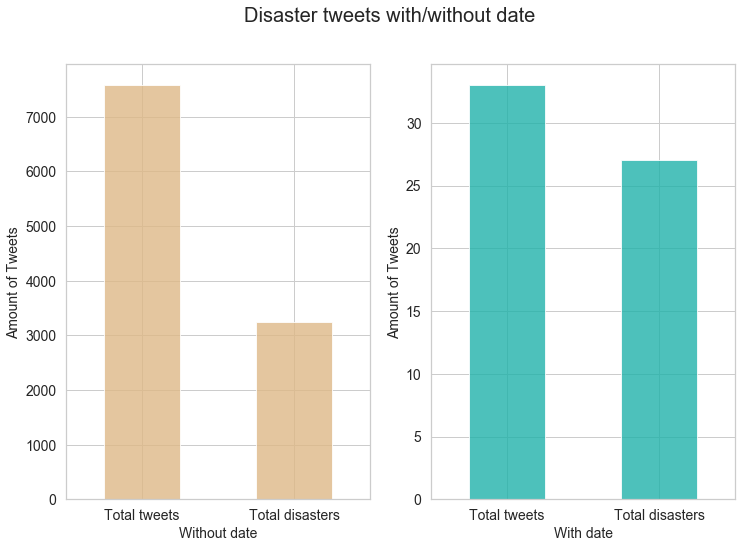

In [46]:

plt.subplot(1, 2, 1)

f1=date_count.set_index('with_date').loc[0].plot(kind='bar', figsize=(12, 8), stacked =False , color="burlywood", alpha=0.8, fontsize=14)
plt.subplot(1, 2, 2)
#date_count.set_index('with_date').loc[1].plot(kind='bar', figsize=(12, 8), stacked = False,cmap="Spectral", alpha=0.7)
f2=date_count.set_index('with_date').loc[1].plot(kind='bar', figsize=(12, 8), stacked = False,color="lightseagreen", alpha=0.8, fontsize=14)

f1.set_ylabel('Amount of Tweets', fontsize=14)
f2.set_ylabel('Amount of Tweets', fontsize=14)
f1.set_xlabel('Without date', fontsize=14)
f2.set_xlabel('With date', fontsize=14)
f1.set_xticklabels(f1.get_xticklabels(),rotation=0)
f2.set_xticklabels(f2.get_xticklabels(),rotation=0)
plt.suptitle("Disaster tweets with/without date", fontsize=20)
plt.savefig('Grafico1.png')

In [47]:
df['with_time']= df.text.str.contains("((([0]?[1-9]|1[0-2])(:|\.)[0-5][0-9]((:|\.)[0-5][0-9])?( )?(AM|am|aM|Am|PM|pm|pM|Pm))|(([0]?[0-9]|1[0-9]|2[0-3])(:|\.)[0-5][0-9]((:|\.)[0-5][0-9])?))", regex=True)
df['with_time']=df['with_time'].astype(int)
time_count = df.groupby(['with_time'])['target'].agg({'sum','count'}).reset_index()
time_count.rename(columns={'sum' : 'Total disasters', 'count':'Total tweets'}, inplace=True)
time_count.head()

,with_time,Total tweets,Total disasters
0,0,7485,3179
1,1,128,92


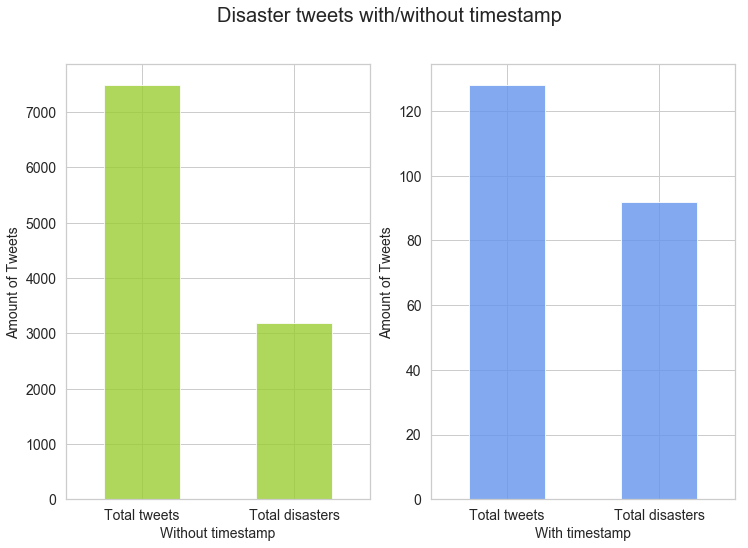

In [48]:
plt.subplot(1, 2, 1)

f1=time_count.set_index('with_time').loc[0].plot(kind='bar', figsize=(12, 8), stacked =False , color="yellowgreen", alpha=0.8, fontsize=14)
plt.subplot(1, 2, 2)
#date_count.set_index('with_date').loc[1].plot(kind='bar', figsize=(12, 8), stacked = False,cmap="Spectral", alpha=0.7)
f2=time_count.set_index('with_time').loc[1].plot(kind='bar', figsize=(12, 8), stacked = False,color="cornflowerblue", alpha=0.8, fontsize=14)

f1.set_ylabel('Amount of Tweets', fontsize=14)
f2.set_ylabel('Amount of Tweets', fontsize=14)
f1.set_xlabel('Without timestamp', fontsize=14)
f2.set_xlabel('With timestamp', fontsize=14)
f1.set_xticklabels(f1.get_xticklabels(),rotation=0)
f2.set_xticklabels(f2.get_xticklabels(),rotation=0)
plt.suptitle("Disaster tweets with/without timestamp", fontsize=20)
plt.savefig('Grafico2.png')

In [49]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

df['textnoturl']=df['text'].agg(lambda x : remove_URL(x))


In [50]:
df['#words']=df['text'].str.split().map(lambda x: len(x))

In [51]:
def find_match2(str):
    res = ' '
    aux=str.split('#')
    aux.pop(0)
    if aux:
        for a in aux:
            if a:
                res = res+' ' + a.split()[0]
    return res

In [52]:
df['hashtags']=df['text'].agg(lambda x: find_match2(x))
df.head()
df['#hashtags']=df['hashtags'].str.split().map(lambda x: len(x))
df.head()

,keyword,location,text,target,long,equal_words,Tags,with_url,with_date,with_time,textnoturl,#words,hashtags,#hashtags
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,0,0,0,0,0,Our Deeds are the Reason of this #earthquake M...,13,earthquake,1
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,0,0,0,0,0,Forest fire near La Ronge Sask. Canada,7,,0
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,0,0,0,0,0,All residents asked to 'shelter in place' are ...,22,,0
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,0,0,0,0,0,"13,000 people receive #wildfires evacuation or...",8,wildfires,1
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,0,0,0,0,0,Just got sent this photo from Ruby #Alaska as ...,16,Alaska wildfires,2


In [53]:
df["located"] = df["location"] == df["location"]
df.loc[df["located"] == True,"located"] = 1
df.loc[df["located"] == False ,"located"] = 0
df["located"] = df["located"].astype(int)

In [54]:
df['has_keyword']=df['keyword'] == df['keyword']
df.loc[df["has_keyword"] == True,"has_keyword"] = 1
df.loc[df["has_keyword"] == False ,"has_keyword"] = 0

df['has_keyword']=df['has_keyword'].astype(int)

In [55]:
dfcor = df.drop(columns=['keyword', 'location', 'text', 'textnoturl', 'hashtags'])
len(dfcor)

7613

In [56]:
df2=dfcor.drop(columns=['long', '#words']).groupby('target').agg(['sum'])
level0= df2.columns.get_level_values(0)
level1= df2.columns.get_level_values(1)
df2.columns = level0 + '_' + level1
df2.head()

,equal_words_sum,Tags_sum,with_url_sum,with_date_sum,with_time_sum,#hashtags_sum,located_sum,has_keyword_sum
target,,,,,,,,
0,867,1854,1799,6,36,1697,2884,4323
1,629,905,2172,27,92,1701,2196,3229


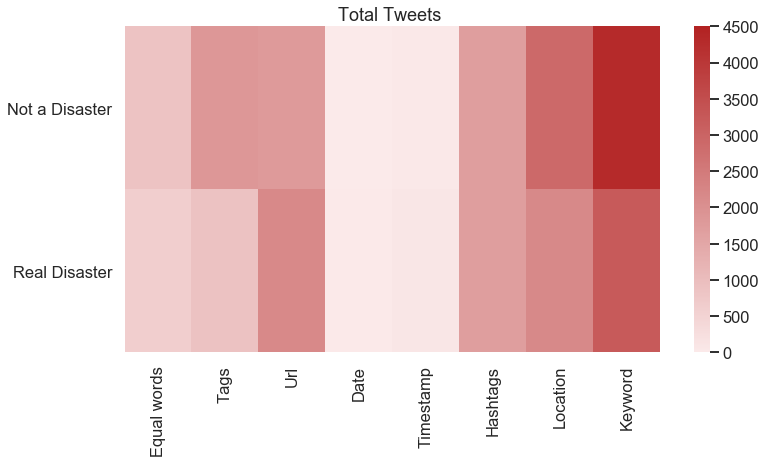

In [57]:
sns.set_context("talk")
plt.figure(figsize=(12,6))
cmap = sns.light_palette(color='firebrick',as_cmap=True)
fig=sns.heatmap(df2, vmin=0, vmax=4500, cmap=cmap,
            xticklabels=['Equal words', 'Tags', 'Url', 'Date','Timestamp', 'Hashtags', 'Location', 'Keyword'], 
            yticklabels=['Not a Disaster', 'Real Disaster'], robust=True)
fig.set(xlabel="",
      ylabel="", title="Total Tweets ")

fig.set_yticklabels(fig.get_yticklabels(), rotation =0)
plt.savefig('heat.png',bbox_inches='tight')

In [58]:
dfcor.has_keyword

0       0
1       0
2       0
3       0
4       0
       ..
7608    0
7609    0
7610    0
7611    0
7612    0
Name: has_keyword, Length: 7613, dtype: int32

In [59]:
df3=dfcor.drop(columns=['long', '#words', 'has_keyword']).groupby('target').agg(['mean'])
level0= df3.columns.get_level_values(0)
level1= df3.columns.get_level_values(1)
df3.columns = level0 + '_' + level1
df3.head()

,equal_words_mean,Tags_mean,with_url_mean,with_date_mean,with_time_mean,#hashtags_mean,located_mean
target,,,,,,,
0,0.20,0.43,0.41,0.00,0.01,0.39,0.66
1,0.19,0.28,0.66,0.01,0.03,0.52,0.67


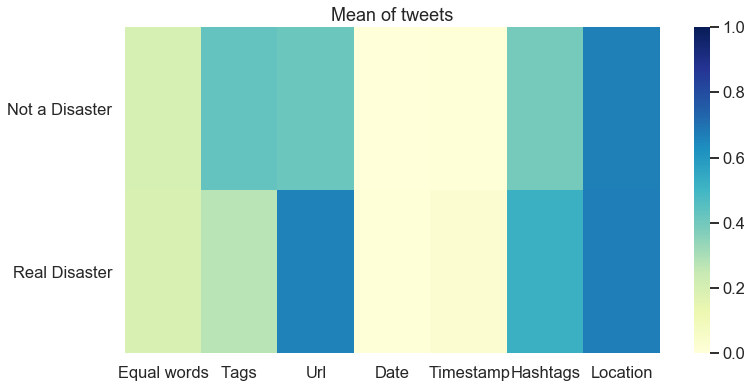

In [60]:
plt.figure(figsize=(12,6))
fig = sns.heatmap(df3, vmin=0, vmax=1, cmap="YlGnBu", 
                  xticklabels=['Equal words', 'Tags', 'Url', 'Date','Timestamp', 'Hashtags', 'Location'], 
                  yticklabels=['Not a Disaster', 'Real Disaster'], robust = True)
fig.set(title='Mean of tweets', xlabel="", ylabel="")

fig.set_yticklabels(fig.get_yticklabels(), rotation =0)
plt.savefig('heatmean.png',bbox_inches='tight')

In [61]:
dfcorr= dfcor.corr() 
dfcorr

,target,long,equal_words,Tags,with_url,with_date,with_time,#words,#hashtags,located,has_keyword
target,1.00,0.18,-0.01,-0.10,0.25,0.05,0.08,0.04,0.06,0.01,-0.05
long,0.18,1.00,0.20,0.06,0.28,0.03,0.05,0.84,0.21,0.05,0.07
equal_words,-0.01,0.20,1.00,-0.03,-0.04,-0.02,0.02,0.28,-0.03,-0.00,0.01
Tags,-0.10,0.06,-0.03,1.00,-0.22,-0.03,-0.04,0.04,-0.05,0.04,0.04
with_url,0.25,0.28,-0.04,-0.22,1.00,0.05,0.03,-0.12,0.18,0.04,0.03
with_date,0.05,0.03,-0.02,-0.03,0.05,1.00,0.33,-0.00,0.03,0.01,0.01
with_time,0.08,0.05,0.02,-0.04,0.03,0.33,1.00,0.04,0.04,-0.00,-0.03
#words,0.04,0.84,0.28,0.04,-0.12,-0.00,0.04,1.00,0.05,0.05,0.05
#hashtags,0.06,0.21,-0.03,-0.05,0.18,0.03,0.04,0.05,1.00,-0.00,-0.02
located,0.01,0.05,-0.00,0.04,0.04,0.01,-0.00,0.05,-0.00,1.00,0.13


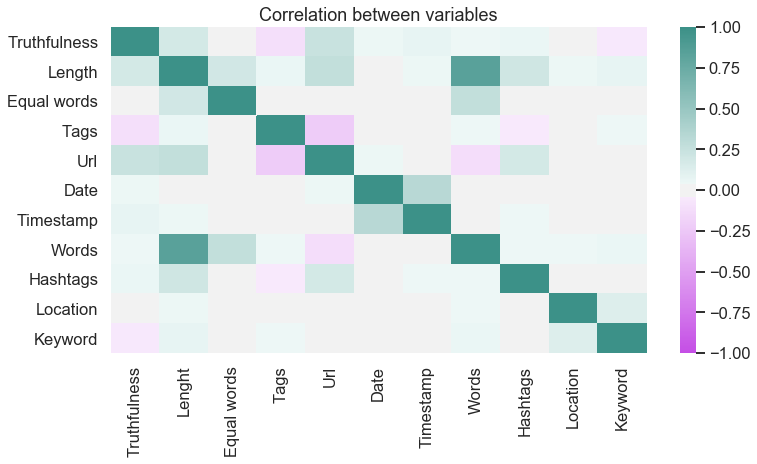

In [62]:
plt.figure(figsize=(12,6))
cmap = sns.diverging_palette(295, 180, s=80, l=55, as_cmap=True)
fig=sns.heatmap(dfcorr, vmin=-1, vmax=1, cmap=cmap,
            xticklabels=['Truthfulness','Lenght','Equal words', 'Tags', 'Url', 'Date', 'Timestamp','Words', 'Hashtags', 'Location', 'Keyword'], 
            yticklabels=['Truthfulness','Length','Equal words', 'Tags', 'Url', 'Date', 'Timestamp', 'Words', 'Hashtags', 'Location', 'Keyword'])
fig.set(xlabel="",
      ylabel="", title='Correlation between variables')

fig.set_yticklabels(fig.get_yticklabels(), rotation =0)

plt.savefig('heatcorr.png',bbox_inches='tight')